In [1]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! mkdir ./images

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download grassknoted/asl-alphabet
! unzip asl-alphabet.zip -d ./images/
! rm asl-alphabet.zip

In [ ]:
! kaggle datasets download danrasband/asl-alphabet-test
! unzip asl-alphabet-test.zip -d ./test-images/
! rm asl-alphabet-test.zip

import os

for letter in os.scandir("./test-images/asl-alphabet-test/"):
    for entry in os.scandir(letter.path):
        os.rename(entry.path, f"./images/asl_alphabet_train/asl_alphabet_train/{letter.name}/{entry.name}")
! rm -rf test-images/

In [23]:
from keras import layers
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing import image_dataset_from_directory
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

def load_data():
    train = image_dataset_from_directory("./images/asl_alphabet_train/asl_alphabet_train",
                                        labels="inferred", color_mode="grayscale",
                                        image_size=(80, 80), validation_split=.2,
                                        subset="training", seed=1234321)
    valid = image_dataset_from_directory("./images/asl_alphabet_train/asl_alphabet_train",
                                        labels="inferred", color_mode="grayscale",
                                        image_size=(80, 80), validation_split=.2,
                                        subset="validation", seed=1234321)
    return train, valid

In [24]:
from typing import List

def get_model(size_list: List[List[int]]) -> List[Sequential]:
    res = []
    for sizes in size_list:
        model = Sequential()
        model.add(layers.Input((80, 80, 1)))
        model.add(layers.Flatten())
        model.add(layers.experimental.preprocessing.Rescaling(1./255))
        for size in sizes:
            model.add(layers.Dropout(.5))
            model.add(layers.Dense(size, activation="relu")) 
        model.add(layers.Dense(29, activation="softmax"))
        decay = ExponentialDecay(5e-5, decay_steps=15000,
                                 decay_rate=.9)
        model.compile(optimizer=Adam(learning_rate=decay), 
                      loss=SparseCategoricalCrossentropy(),
                                 metrics=["accuracy"])
        res.append(model)

    return res

#35
def generate_models():
    sizes = [
             [3200],
             [3200, 1600],
             [3200, 1600, 800]
             ]
    return get_model(sizes)

In [26]:
import time
metrics = []
models = generate_models()
for model in models:
    print(model.summary())
start = time.time()
for model in models:
    train, valid = load_data()
    hist = model.fit(train, epochs=125, validation_data=valid)
    train = model.evaluate(train)
    valid = model.evaluate(valid)
    metrics.append((hist, train, valid))
print("Finished in", (time.time() - start) / 3600, "hours")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 6400)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6400)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3200)              20483200  
_________________________________________________________________
dense_10 (Dense)             (None, 29)                92829     
Total params: 20,576,029
Trainable params: 20,576,029
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)   

In [27]:
for i, model in enumerate(models):
    model.save("model" + str(i))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model0/assets
INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


In [28]:
import pandas as pd
df = pd.DataFrame(columns=["train_accuracy", "val_accuracy", "history"])
for i, info in enumerate(metrics):
    temp = {"train_accuracy": info[1][1], "val_accuracy": info[2][1],
            "history": info[0].history}
    df = df.append(temp, ignore_index=True)

display(df)
df.to_csv('./results.csv')

,train_accuracy,val_accuracy,history
0,0.953582,0.938432,"{'loss': [2.8816637992858887, 2.36728096008300..."
1,0.960496,0.946683,"{'loss': [3.072822093963623, 2.533557176589966..."
2,0.941177,0.925856,"{'loss': [3.289787769317627, 2.855891227722168..."


In [29]:
! rm -rf finished_models
! rm finished_models.zip
! mkdir finished_models
! cp -r model* finished_models/
! cp results.csv finished_models/
! zip -r finished_models.zip finished_models 

rm: cannot remove 'finished_models.zip': No such file or directory
  adding: finished_models/ (stored 0%)
  adding: finished_models/model0/ (stored 0%)
  adding: finished_models/model0/variables/ (stored 0%)
  adding: finished_models/model0/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: finished_models/model0/variables/variables.index (deflated 59%)
  adding: finished_models/model0/saved_model.pb (deflated 87%)
  adding: finished_models/model0/assets/ (stored 0%)
  adding: finished_models/model1/ (stored 0%)
  adding: finished_models/model1/variables/ (stored 0%)
  adding: finished_models/model1/variables/variables.data-00000-of-00001 (deflated 38%)
  adding: finished_models/model1/variables/variables.index (deflated 61%)
  adding: finished_models/model1/saved_model.pb (deflated 89%)
  adding: finished_models/model1/assets/ (stored 0%)
  adding: finished_models/model2/ (stored 0%)
  adding: finished_models/model2/variables/ (stored 0%)
  adding: finished_models/model2

In [30]:
data = image_dataset_from_directory("./images/asl_alphabet_train/asl_alphabet_train",
                                    labels="inferred", color_mode="grayscale",
                                    image_size=(80, 80))

i = 0
for model in models:
    print("Model" + i)
    print(model.evaluate(data))
    print(model.evaluate(train))
    print(model.evaluate(valid))

Found 87870 files belonging to 29 classes.
2746/2746 [==============================] - 58s 21ms/step - loss: 0.2217 - accuracy: 0.9506
[0.22167375683784485, 0.9505519270896912]
2746/2746 [==============================] - 57s 21ms/step - loss: 0.1976 - accuracy: 0.9577
[0.19763822853565216, 0.9577330350875854]
2746/2746 [==============================] - 58s 21ms/step - loss: 0.2511 - accuracy: 0.9381
[0.25105783343315125, 0.9381130933761597]


In [31]:
! mv finished_models.zip ./drive/MyDrive/"Colab Notebooks"/

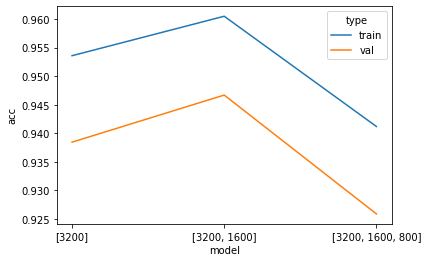

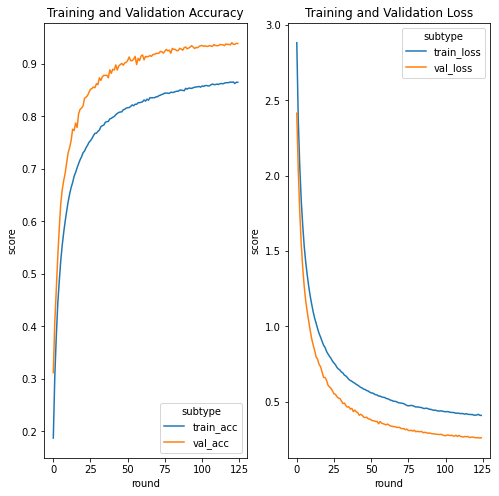

Found 87870 files belonging to 29 classes.
Using 70296 files for training.
Found 87870 files belonging to 29 classes.
Using 17574 files for validation.


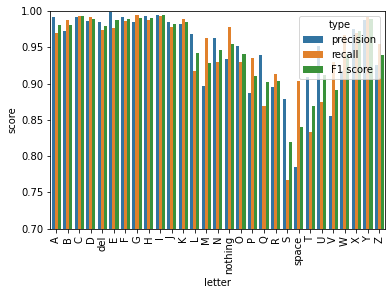

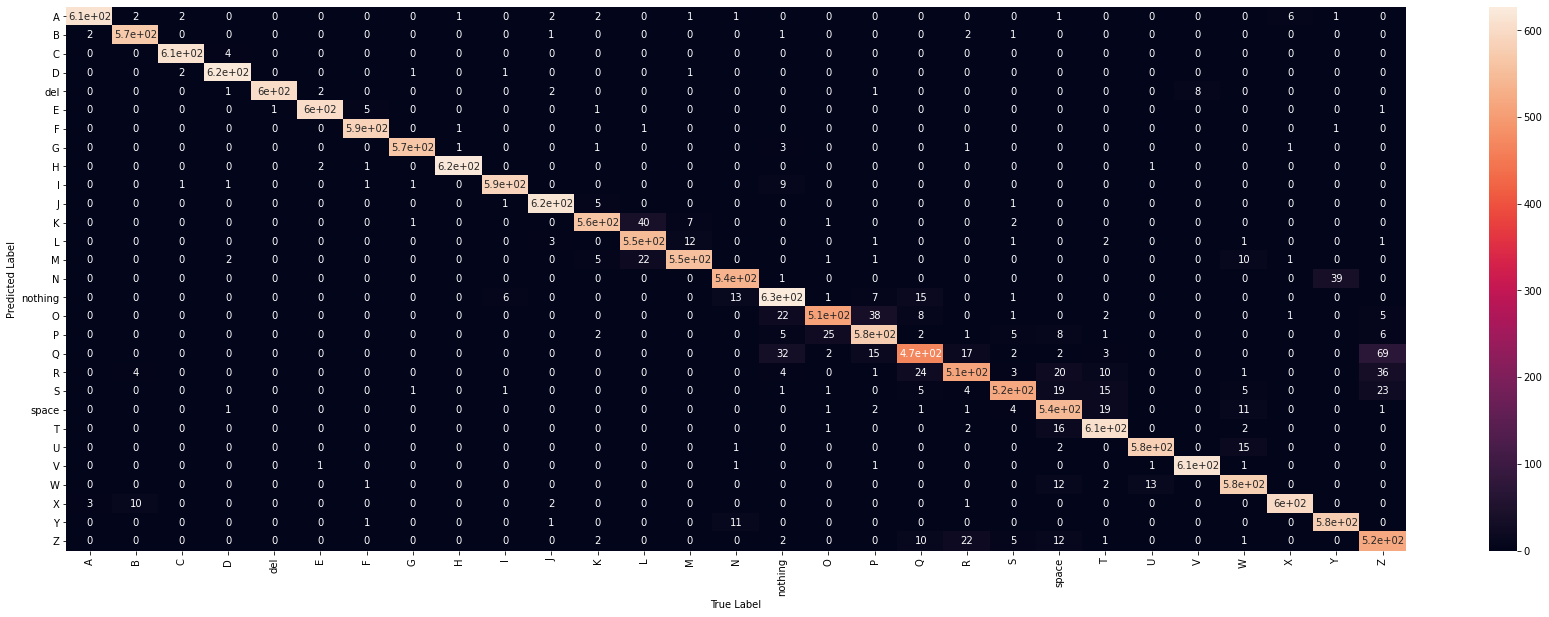

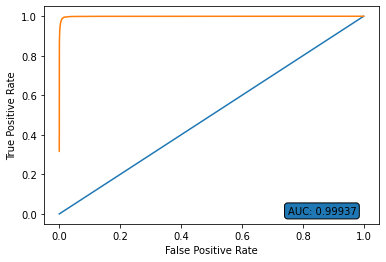

In [41]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.nn import softmax
from sklearn.preprocessing import label_binarize

letters = [chr(i) for i in range(ord("A"), ord("Z") + 1)]
letters.insert(4, "del")
letters.insert(15, "nothing")
letters.insert(21, "space")

letter_map = {i: letter for i, letter in enumerate(letters)}

def generate_accuracy_graph(res, hist):
    sns.lineplot(data=res, x="model", y="acc", hue="type")
    plt.show()
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=hist[(hist["model"] == 0) & (hist["type"] == "acc")],
                 x="round", y="score", hue="subtype")
    plt.title("Training and Validation Accuracy")
    plt.subplot(1, 2, 2)
    sns.lineplot(data=hist[(hist["model"] == 0) & (hist["type"] == "loss")],
                 x="round", y="score", hue="subtype")
    plt.title("Training and Validation Loss")
    plt.show()

def graph_report(report, conf_matrix, rates, auc):
    data = pd.DataFrame(columns=["letter", "score", "type"])
    for letter in letters:
        precision = report[letter]["precision"]
        recall = report[letter]["recall"]
        f1 = report[letter]["f1-score"]
        data = data.append({"letter": letter,
                            "score": precision,
                            "type": "precision"}, ignore_index=True)
        data = data.append({"letter": letter,
                            "score": recall,
                            "type": "recall"}, ignore_index=True)
        data = data.append({"letter": letter,
                            "score": f1,
                            "type": "F1 score"}, ignore_index=True)
    sns.barplot(data=data, x="letter", y="score", hue="type")
    plt.xticks(rotation=90)
    plt.ylim(.7, 1)
    plt.show()
    plt.figure(figsize=(30, 10))
    sns.heatmap(conf_matrix, annot=True, square=False,
                xticklabels=letter_map.values(), yticklabels=letter_map.values())
    plt.xticks(rotation=90)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()
    sns.lineplot(x=[0, 1], y=[0, 1])
    ax = sns.lineplot(x=rates[0], y=rates[1])
    ax.text(.75, 0, "AUC: {:.5f}".format(auc), bbox={"boxstyle": "round"})
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

def score(model, test_data):
    target = None
    preds = None
    class_probs = None
    for image_batch, label_batch in test_data.as_numpy_iterator():
        if target is None:
            target = label_batch
        else:
            target = np.append(target, label_batch)
        predictions = model.predict(image_batch)
        classes = []
        scores = []
        ins_class_probs = []
        for i, p in enumerate(predictions):
            score = softmax(p)
            classes.append(np.argmax(score))
            scores.append(score[label_batch[i]])
            ins_class_probs.append(score.numpy())
        if preds is None:
            preds = np.array(classes)
            class_probs = np.array(ins_class_probs)
        else:
            preds = np.append(preds, np.array(classes))
            class_probs = np.append(class_probs, np.array(ins_class_probs))

    pred = pd.Series(preds).replace(letter_map)
    target = pd.Series(target).replace(letter_map)
    report = classification_report(target, pred, output_dict=True)
    bin_targets = label_binarize(target, classes=list(letter_map.values()))
    auc_score = roc_auc_score(bin_targets, class_probs.reshape((-1, 29)), average="micro")
    conf_matrix = confusion_matrix(target, pred)
    fpr, tpr, _ = roc_curve(bin_targets.ravel(), class_probs)
    return report, conf_matrix, (fpr, tpr), auc_score

def generate_visuals():
    res = pd.read_csv("finished_models/results.csv")
    history = pd.DataFrame(columns=["model", 'type', "subtype", 'score', 'round'])
    for i, hist in enumerate(res["history"]):
        data = json.loads(hist.replace("'", '"'))
        for j in range(len(data['loss'])):
            history = history.append({"model": i, 'type': 'loss', "subtype": "train_loss",
                                      'score': data['loss'][j],
                                      "round": j},
                                     ignore_index=True)
            history = history.append({"model": i, 'type': 'acc', "subtype": "train_acc",
                                      'score': data['accuracy'][j],
                                      "round": j},
                                     ignore_index=True)
            history = history.append({"model": i, 'type': "loss", "subtype": 'val_loss', 'score': data['val_loss'][j],
                                      "round": j},
                                     ignore_index=True)
            history = history.append({"model": i, 'type': "acc", "subtype": 'val_acc', 'score': data['val_accuracy'][j],
                                      "round": j},
                                     ignore_index=True)
    final_hist = pd.DataFrame(columns=["acc", "type"])
    for item in res.iterrows():
        final_hist = final_hist.append({"acc": item[1]["train_accuracy"],
                                        "type": "train"}, ignore_index=True)
        final_hist = final_hist.append({"acc": item[1]["val_accuracy"],
                                        "type": "val"}, ignore_index=True)
    final_hist["model"] = ["[3200]", "[3200]", "[3200, 1600]",
                       "[3200, 1600]", "[3200, 1600, 800]",
                       "[3200, 1600, 800]"]

    generate_accuracy_graph(final_hist, history)
    model = load_model("./finished_models/model1")
    report, conf_matrix, rates, auc = score(model, load_data()[1])
    graph_report(report, conf_matrix, rates, auc)

generate_visuals()